In [27]:
import scipy.io as sio
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from fieldmodel import GeodesicFieldModel as GFM
from fieldmodel import utilities as util
from fieldmodel import plotting

In [2]:
sx_file = '../data/source.X.mat'
sx = sio.loadmat(sx_file)['x'].squeeze()

sy_file = '../data/source.Y.mat'
sy = sio.loadmat(sy_file)['y'].squeeze()

tx_file = '../data/target.X.mat'
tx = sio.loadmat(tx_file)['x'].squeeze()

ty_file = '../data/target.Y.mat'
ty = sio.loadmat(ty_file)['y'].squeeze()

In [3]:
dist_file = '../data/distance.mat'
dist = sio.loadmat(dist_file)['apsp']

In [4]:
field_file = '../data/scalar_field.mat'
field = sio.loadmat(field_file)['field'].squeeze()

In [22]:
G = GFM.FieldModel(amplitude=False, metric='pearson', hood_size=40)
G.fit(data=field, distances=dist, x=tx, y=ty)

5.0


/Users/kristianeschenburg/Documents/Code/fieldmodel/fieldmodel/plotting.py:286: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


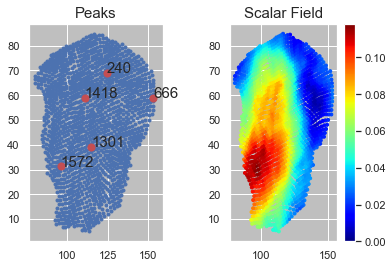

In [163]:
n_size = 13
inds = np.arange(field.shape[0])

# for each index in scalar field
# find all neighbors within given distance
# and store in dictionary
neighbs = {k: None for k in inds}
for k in inds:
    h = np.where(np.asarray(dist[k, :]) <= n_size)[0]
    neighbs[k] = h

# identify most-correlated signal in neighborhood
maxsignal = {k: None for k in inds}
for k in inds:

    temp = np.ma.masked_invalid(field[neighbs[k]])
    temp = temp.argmax()
    maxsignal[k] = neighbs[k][temp]

unique_peaks = np.unique(list(maxsignal.values()))
up = np.asarray(unique_peaks[np.argsort((-1*field)[unique_peaks])])

passed = np.zeros(len(dist[0, :]))
passed[up] = 1

for peak in up:
    
    # if current peak is passed
    if passed[peak]:
        
        # find points that are farther than n_size away
        zinds = np.where((dist[peak, :] < n_size) & (dist[peak, :] > 0))[0]
        zinds = list(set(up).intersection(zinds))
        passed[zinds] = 0

print(passed.sum())
peaks = np.where(passed)[0]

plotting.plot_peaks(peaks=peaks, sfield=field, x=tx, y=ty)

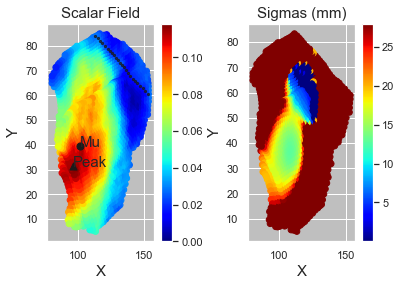

In [23]:
F = G.plot(field='sigma')

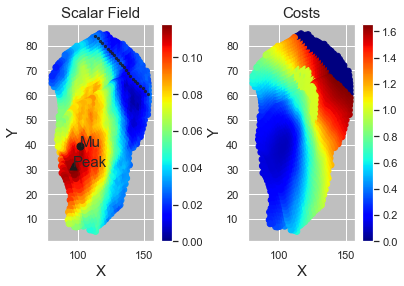

In [24]:
F = G.plot(field='cost')

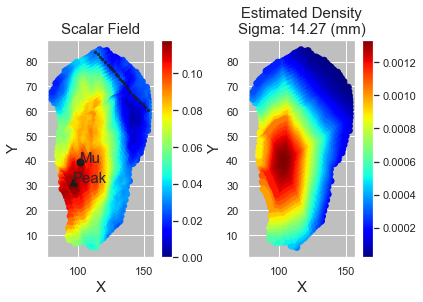

In [25]:
F = G.plot(field='pdf')